In [4]:
!pip install datasets
!pip install evaluate
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from evaluate import load
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Determine whether a GPU is available, and set it to gpu if available else set it to cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
file_path = 'manually_created_tos.csv'
data = pd.read_csv(file_path)
# Data Preprocessing
data = data.dropna()  # Drop missing values
data['label'] = data['label'].map({'Risky': 0, 'Safe': 1, 'Information': 2})  # Encode label

# Splitting the dataset into train and test subsets
train_texts, test_texts, train_labels, test_labels = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Convert the split data into Hugging Face Dataset format
train_data = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_data = Dataset.from_dict({"text": test_texts, "label": test_labels})

In [15]:
# Loading the tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [16]:
# Tokenizing the dataset
def preprocess_function(review):
    return tokenizer(review["text"], truncation=True, padding="max_length", max_length=512)

In [22]:
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

tokenized_train = tokenized_train.with_format("torch")
tokenized_test = tokenized_test.with_format("torch")

accuracy_metric = load("accuracy")

Map:   0%|          | 0/953 [00:00<?, ? examples/s]

Map:   0%|          | 0/239 [00:00<?, ? examples/s]

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

In [44]:
# Defining training arguments and the Trainer
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=6,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=1e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    seed=42,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Training the model
trainer.train()

# Evaluating the model
predictions = trainer.predict(tokenized_test)
logits = predictions.predictions
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_test["label"]

# Calculate probabilities (softmax on logits)
probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=1)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-dfcd0164cf65>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.327462,0.786611
2,No log,2.380190,0.786611
3,No log,2.421794,0.790795
4,No log,2.406149,0.786611
5,No log,2.370142,0.799163
6,No log,2.331242,0.794979


In [45]:
# Calculating the accuracy and confusion matrix
accuracy = compute_metrics((predictions.predictions, true_labels))["accuracy"]
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print evaluation results
print(f"Accuracy: {accuracy}")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy: 0.799163179916318
Precision:  [0.78947368 0.91836735 0.74736842]
Recall:  [0.81521739 0.75       0.81609195]
F1 Score:  [0.80213904 0.82568807 0.78021978]


Confusion Matrix:
[[75  0 17]
 [ 8 45  7]
 [12  4 71]]


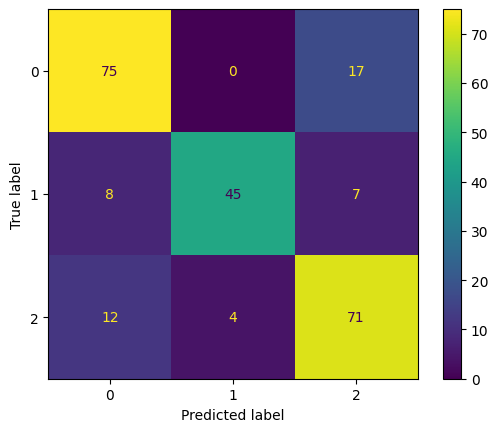

In [46]:
print(f"Confusion Matrix:\n{conf_matrix}")
cm_display = ConfusionMatrixDisplay(conf_matrix)
cm_display.plot()
plt.show()